## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [346]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [347]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [348]:
# show the total number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [349]:
#checking number of unique users
df.nunique()['user_id']

290584

d. The proportion of users converted.

In [350]:
#checking proportions of converted users
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [351]:
number_times = df.query('group == "control" and landing_page == "new_page" or group == "treatment" and landing_page == "old_page"' ).count()
number_times

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [352]:
# checking null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [353]:
# making copy of dataframe
df2 = df.copy()

# preparing list
df_list = df2.index[((df2['group'] == 'treatment') == (df2['landing_page'] =='new_page')) == False].tolist()

# remove incorrect rows
df2.drop(df_list, inplace=True)

df2['user_id'].count()
                         

290585

In [354]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [355]:
# check the number of unique users 

df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [356]:
# check duplicated users
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [357]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [358]:
#Remove one of theduplicated rows
df2.drop(labels=2893, inplace=True)

In [359]:
# check if we have more duplicates 
df2['user_id'].duplicated().sum() 

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [360]:
# calculate the average of the converted column
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [361]:
# the probability for the 'control' group
df2_control = df[df['group'] == 'control']['converted'].mean()
df2_control

0.12039917935897611

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [362]:
# the probability for the 'treatment' group
df2_treatment = df[df['group'] == 'treatment']['converted'].mean()
df2_treatment

0.11891957956489856

d. What is the probability that an individual received the new page?

In [363]:
# the probability for the new_page
print((df['landing_page'] == 'new_page').mean())

0.5


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

### ANSWER:
** The result above shows us that individuals in the control group had a conversion rate of 12.04% and individuals in the treatment grounp had a conversion rate of 11.89%. In conclusion, there is no sufficient evidence, that new treatement page leads to more conversions. This hypotesis needs more investigation  **

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

** The hypotheses looks like:
   Ho: Pnew - Pold <= 0
   H1: Pnew - Pold > 0 **

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [364]:
#counting convertion rate for p_new
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [365]:
#counting convertion rate for p_old
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [366]:
#counting difference in convert rate 

diff_convert_rate = p_new - p_old
diff_convert_rate

0.0

c. What is $n_{new}$?

In [367]:
#count n_new
n_new = df2[df2['group'] == 'treatment']['user_id'].count()
n_new

145310

d. What is $n_{old}$?

In [368]:
# count n_old
n_old = df2[df2['group'] == 'control']['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [369]:
# simulation for Nnew using method np.random.choice
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
new_page_converted

0.12147133714128415

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [370]:
#simulation for Nold using method np.random.choice
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_new, (1-p_old)]).mean()
old_page_converted

0.12008342855569476

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [371]:
# difference into simulated values 
diff_val = new_page_converted.mean() - old_page_converted.mean()
diff_val


0.0013879085855893897

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [372]:
p_diffs = []
for _ in range(10000):
    new_page = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page = np.random.choice([1, 0], size=n_old, p=[p_new, (1-p_old)]).mean()
    diff = new_page - old_page
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [373]:
# convert to numpy array
p_diffs = np.array(p_diffs)

In [374]:
data_diff = df2_treatment - df2_control
data_diff

-0.0014795997940775518

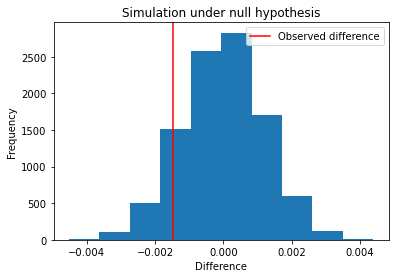

In [375]:

# plot the sampling distribution 
plt.hist(p_diffs);
plt.axvline(x=data_diff, color='red', label='Observed difference');
plt.title('Simulation under null hypothesis');
plt.xlabel('Difference');
plt.ylabel('Frequency');
plt.legend()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [376]:
#calculate mean of p_diffs
p_value = (p_diffs > data_diff).mean()
p_value

0.8897

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

### ANSWER: 
***In this part of the project I have computed p_value for our hypothesis test. The idea of null hypothesis have been that difference in means would be less than or equal 0  and the alternative of the difference would be greater than 0. Since the difference is less than zero and the p-value is very large. So, it means we don't have sufficient evidence that the new_page has a higher conversion rate than the old_page and we can't reject the null hypothesis **

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [377]:
import statsmodels.api as sm

convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])

n_old = df2[df2['group'] == 'control']['user_id'].count()
n_new = df2[df2['group'] == 'treatment']['user_id'].count()

In [378]:
convert_new, convert_old

(17264, 17489)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [379]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],[n_old, n_new], alternative='larger')

z_score, p_value

(1.3109241984234394, 0.09494168724097551)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The conversion rate of the new landing page is only 1.31 and the p-value is 0.094. As a result, the old page is better then new one.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

** Linier regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [380]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])

In [381]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [382]:
lm = sm.OLS(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [383]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Tue, 22 Dec 2020   Prob (F-statistic):              0.190
Time:                        12:36:58   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

### ANSWER:
**P-value is associated with ab_page and is equal to 0.19. 
In Parts II, III the p-values were computed using different approaches, in both cases neither null hypothesis nor alternative hypothesis does not have sufficient statisticaly significant. 
**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

### ANSWER:
**Considering other factors to add to this regression model would be a good idea. Probably we need to take into consideration variables from date/time, so on.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [384]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [385]:
#check rows and columns
df_new.head(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [386]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [387]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [388]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
l_model = sm.OLS(df_new['converted'], df_new[['intercept', 'CA', 'US']])
results = l_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.605
Date:                Tue, 22 Dec 2020   Prob (F-statistic):              0.201
Time:                        12:36:59   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1206      0.001    100.045      0.000       0.118       0.123
CA            -0.0053      0.003     -1.787      0.074      -0.011       0.001
US            -0.0010      0.001     -0.746      0.455      -0.004       0.002
==============================================================================
Omnibus:                   125552.384   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414306.036
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         6.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [389]:
l_model = sm.OLS(df_new['converted'], df_new[['intercept','ab_page', 'CA', 'US']])
results = l_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.640
Date:                Tue, 22 Dec 2020   Prob (F-statistic):              0.178
Time:                        12:36:59   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1214      0.001     90.150      0.000       0.119       0.124
ab_page       -0.0016      0.001     -1.307      0.191      -0.004       0.001
CA            -0.0053      0.003     -1.784      0.074      -0.011       0.001
US            -0.0010      0.001     -0.744      0.457      -0.004       0.002
==============================================================================
Omnibus:                   125551.169   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414297.780
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         6.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Answer:
**The p_value for ab_page is still higher than 0.05.
All methods above have shown taht we can't reject null hypothesis.**




<a id='conclusions'></a>
## Conclusions

In conclusion, there is not enough evidence that the new_page raises the conversion rate instead of the old_page and the countries influence the conversion rate. 
In this case, there are two options and one of them they have to stay on the old page, the second one is to develop a new page 

